In [ ]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf

train_dir = "..\isec-ic\\dataset\\train"
validation_dir = "..\isec-ic\\dataset\\valid"
test_dir = "..\isec-ic\\dataset\\test"

current_dir = os.path.dirname(os.path.realpath(__file__ if '__file__' in locals() else os.getcwd()))
train_dir = os.path.join(current_dir, train_dir)
validation_dir = os.path.join(current_dir, validation_dir)
test_dir = os.path.join(current_dir, test_dir)

categories = ["bacterialspot", "healthy","lateblight","leafmold", "mosaicvirus","yellowleafcurlvirus" ,"spidermite","septorialeafspot" ]

def load_images_from_folder(folder):
    images = []
    labels = []
    subfolders = os.listdir(folder)
    for subfolder in subfolders:
        category = subfolder.split("_")[-1].lower()
        if category in categories:
            print("Loading images from category: " + category + " and subfolder: " + subfolder)
            subfolder_path = os.path.join(folder, subfolder)
            for filename in os.listdir(subfolder_path):
                img = Image.open(os.path.join(subfolder_path, filename))
                img = img.resize((64, 64))
                img = np.array(img) / 255.0
                images.append(img)
                labels.append(categories.index(category))
        else:
            print("Category: " + category + " from subfolder " + subfolder + " is not in the list of categories.")
    return np.array(images), np.array(labels)


x_train, y_train = load_images_from_folder(train_dir)
x_validation, y_validation = load_images_from_folder(validation_dir)
x_test, y_test = load_images_from_folder(test_dir)

print("Images loaded successfully")

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout

def create_cnn_model(dropout_rate, learning_rate):
    # Garantir que o dropout_rate esteja no intervalo [0, 1)
    #base_model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
    #base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(64, 64, 3)))
    base_model = Xception(weights='imagenet', include_top=False, input_tensor=Input(shape=(64, 64, 3)))

    for layer in base_model.layers:
        layer.trainable = False

    # Add the dense layers (top layers)
    x = base_model.output
    x = Flatten()(x)  # Flatten the output layer to 1 dimension
    x = Dense(512, activation='relu')(x)   #  First dense layer
    x = Dropout(dropout_rate)(x)  # Dropout to reduce overfitting
    predictions = Dense(len(categories), activation='softmax')(x)  # Output layer

    # Final model
    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

print("Create_cnn_model function loaded")

In [9]:
from swarm.pso import pso
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import numpy as np
from sklearn.metrics import make_scorer, roc_auc_score

# Função para criar o modelo (modificada para usar com KerasClassifier)
def create_model(dropout_rate=0.5, learning_rate=0.001):
    print(f" dropout rate -> {dropout_rate} , learning rate -> {learning_rate}")
    return create_cnn_model(dropout_rate, learning_rate)

# Definir a grade de parâmetros
param_grid = {
    'dropout_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
    'learning_rate': [0.001, 0.01, 0.1]
}

# Criar o modelo para o KerasClassifier
model = KerasClassifier(build_fn=create_model, epochs=5, batch_size=32, verbose=0)

def multiclass_roc_auc_score(y_true, y_pred_proba):
    return roc_auc_score(y_true, y_pred_proba, multi_class='ovr')

# Criando um scorer personalizado
auc_scorer = make_scorer(multiclass_roc_auc_score, needs_proba=True)

# Criar o objeto GridSearchCV com o scorer personalizado
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=KFold(n_splits=5, shuffle=True, random_state=42), scoring=auc_scorer)


# Executar a pesquisa em grelha
grid_result = grid.fit(x_train, y_train)

# Resultados
print("Melhores parâmetros: %s com um score de: %f" % (grid_result.best_params_, grid_result.best_score_))

 dropout rate -> 0.1 , learning rate -> 0.001
 dropout rate -> 0.1 , learning rate -> 0.001
 dropout rate -> 0.1 , learning rate -> 0.001
 dropout rate -> 0.1 , learning rate -> 0.001
 dropout rate -> 0.1 , learning rate -> 0.001
 dropout rate -> 0.1 , learning rate -> 0.01
 dropout rate -> 0.1 , learning rate -> 0.01
 dropout rate -> 0.1 , learning rate -> 0.01
 dropout rate -> 0.1 , learning rate -> 0.01
 dropout rate -> 0.1 , learning rate -> 0.01
 dropout rate -> 0.1 , learning rate -> 0.1
 dropout rate -> 0.1 , learning rate -> 0.1
 dropout rate -> 0.1 , learning rate -> 0.1
 dropout rate -> 0.1 , learning rate -> 0.1
 dropout rate -> 0.1 , learning rate -> 0.1
 dropout rate -> 0.2 , learning rate -> 0.001
 dropout rate -> 0.2 , learning rate -> 0.001
 dropout rate -> 0.2 , learning rate -> 0.001
 dropout rate -> 0.2 , learning rate -> 0.001
 dropout rate -> 0.2 , learning rate -> 0.001
 dropout rate -> 0.2 , learning rate -> 0.01
 dropout rate -> 0.2 , learning rate -> 0.01
 drop

C:\Users\Duarte\anaconda3\envs\tf_38_gpu_ready_backup\lib\site-packages\sklearn\model_selection\_search.py:979: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


 dropout rate -> 0.1 , learning rate -> 0.001
Melhores parâmetros: {'dropout_rate': 0.1, 'learning_rate': 0.001} com um score de: nan


Treinando o modelo com os melhores hiperparâmetros...
Epoch 1/20
375/375 [==============================] - 4s 9ms/step - loss: 1.1632 - accuracy: 0.6234 - val_loss: 0.6491 - val_accuracy: 0.7894
Epoch 2/20
375/375 [==============================] - 3s 9ms/step - loss: 0.5666 - accuracy: 0.8100 - val_loss: 0.6099 - val_accuracy: 0.7975
Epoch 3/20
375/375 [==============================] - 3s 8ms/step - loss: 0.4234 - accuracy: 0.8588 - val_loss: 0.5651 - val_accuracy: 0.8141
Epoch 4/20
375/375 [==============================] - 3s 8ms/step - loss: 0.3260 - accuracy: 0.8907 - val_loss: 0.5174 - val_accuracy: 0.8278
Epoch 5/20
375/375 [==============================] - 3s 8ms/step - loss: 0.2480 - accuracy: 0.9195 - val_loss: 0.6193 - val_accuracy: 0.8188
Epoch 6/20
375/375 [==============================] - 3s 9ms/step - loss: 0.2258 - accuracy: 0.9285 - val_loss: 0.5419 - val_accuracy: 0.8344
Epoch 7/20
375/375 [==============================] - 3s 8ms/step - loss: 0.1681 - accuracy: 0

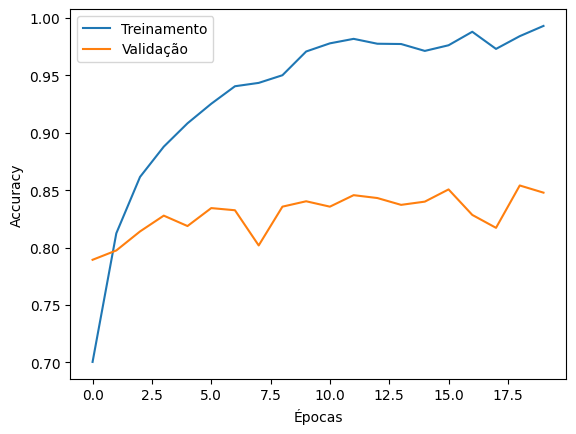

In [10]:
best_learning_rate = 0.001
best_dropout_rate = 0.1

print("Treinando o modelo com os melhores hiperparâmetros...")
best_model = create_cnn_model(best_dropout_rate, best_learning_rate)
best_model_history = best_model.fit(x_train, y_train, epochs=20, batch_size=32, verbose=1, validation_data=(x_validation, y_validation))

best_train_accuracy = best_model_history.history['accuracy'][-1]
best_validation_accuracy = best_model_history.history['val_accuracy'][-1]

print("Melhor Accuracy de Treino:", best_train_accuracy)
print("Melhor Accuracy de Validação:", best_validation_accuracy)

import matplotlib.pyplot as plt

# Plotar as curvas de treino e validação
plt.plot(best_model_history.history['accuracy'], label='Treinamento')
plt.plot(best_model_history.history['val_accuracy'], label='Validação')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [11]:
print("Avaliando o modelo no conjunto de teste...")
loss_test, test_accuracy = best_model.evaluate(x_test, y_test, verbose=0)

print(f"Acurácia no Teste: {test_accuracy}, Loss: {loss_test}")

Avaliando o modelo no conjunto de teste...
Acurácia no Teste: 0.8387500047683716, Loss: 0.7835268378257751
